In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from scipy.spatial.distance import cdist
from PIL import Image
import PIL
import os
from moviepy.editor import VideoFileClip,concatenate_videoclips
import moviepy.editor as mpy
from moviepy.video.fx.all import crop

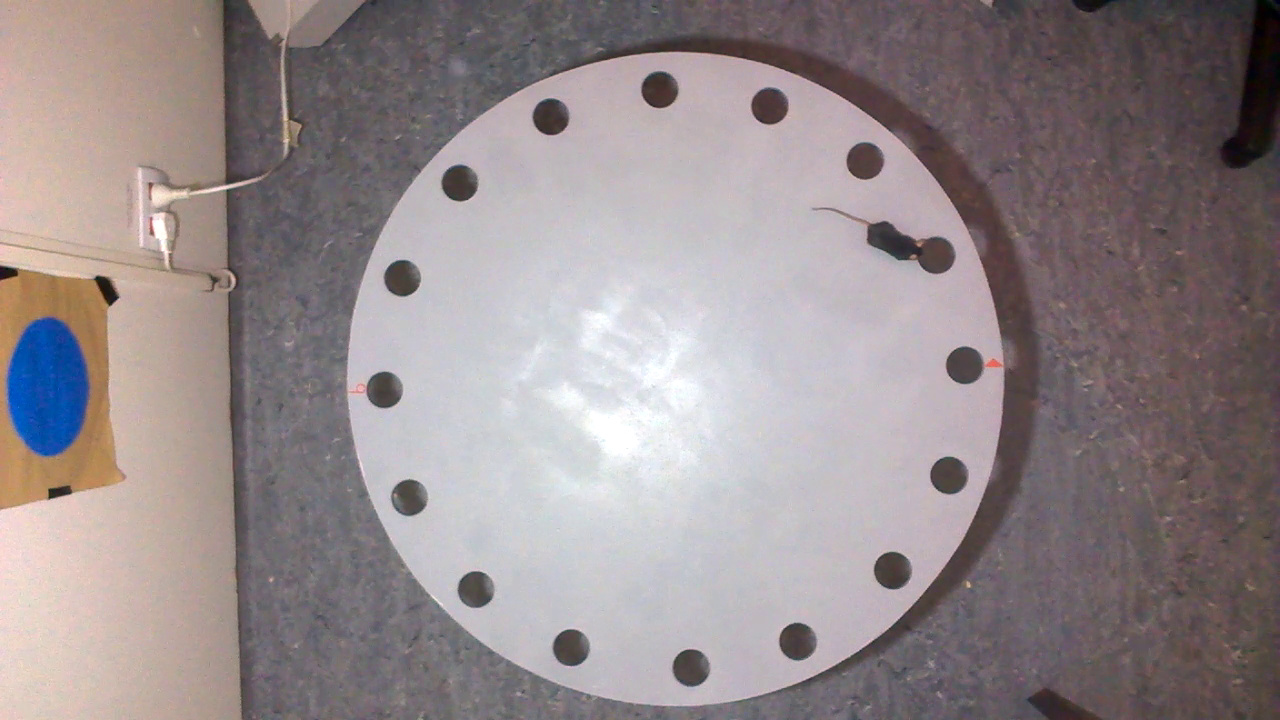

In [42]:
#Read video and extract a frame as example image
video_path = '/content/drive/MyDrive/BARNES - (169. DIA 5 - 1D (J1)).mp4'


def extract_frames_from_video(path):
  vidcap = cv.VideoCapture(path)
  success = True

  while success:
    success, image = vidcap.read()

    if success:
      yield image

frames = extract_frames_from_video(video_path)

for i in range(400):
  img = next(frames)

cv2_imshow(img)

In [43]:
img = Image.fromarray(img)
img = img.convert('RGB')
img.save("cache.jpeg")

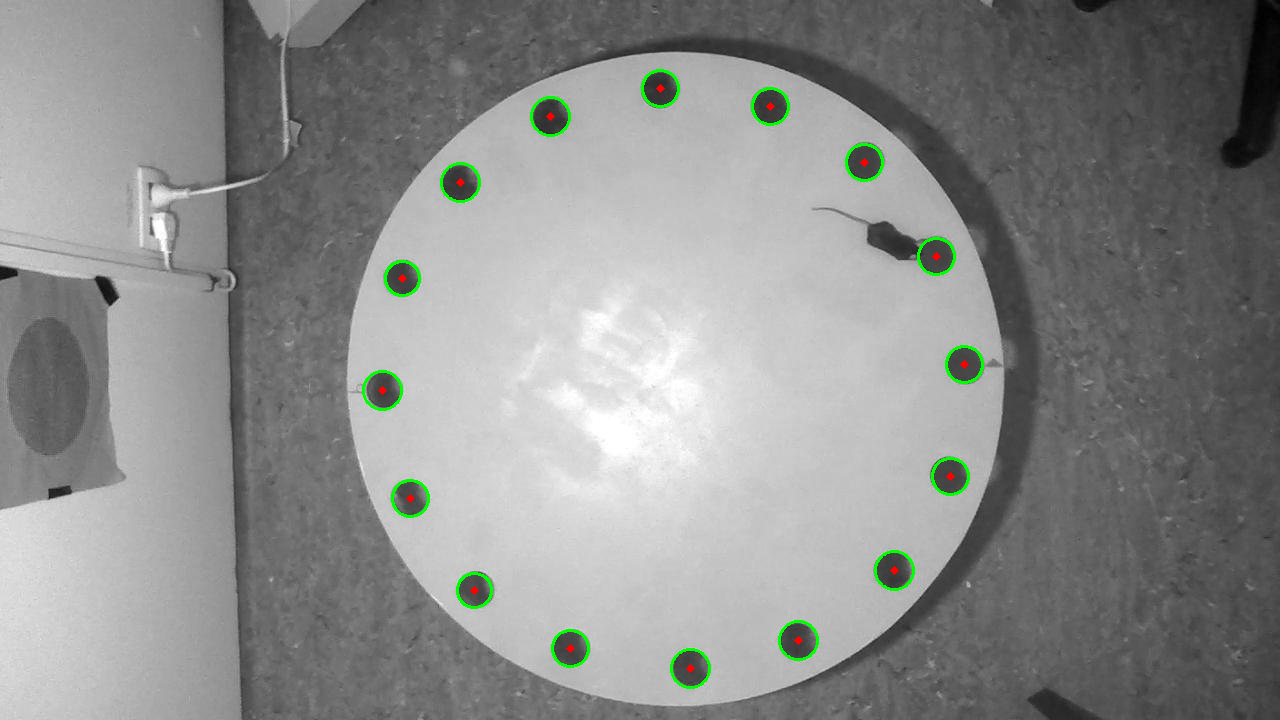

In [59]:
img = cv.imread('cache.jpeg', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
#img = cv.medianBlur(img,13)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)
circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20, param1=50,param2=30,minRadius=10,maxRadius=20)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

circles = circles[0,:,0:2]

assert circles.shape[0] == 16

cv2_imshow(cimg)

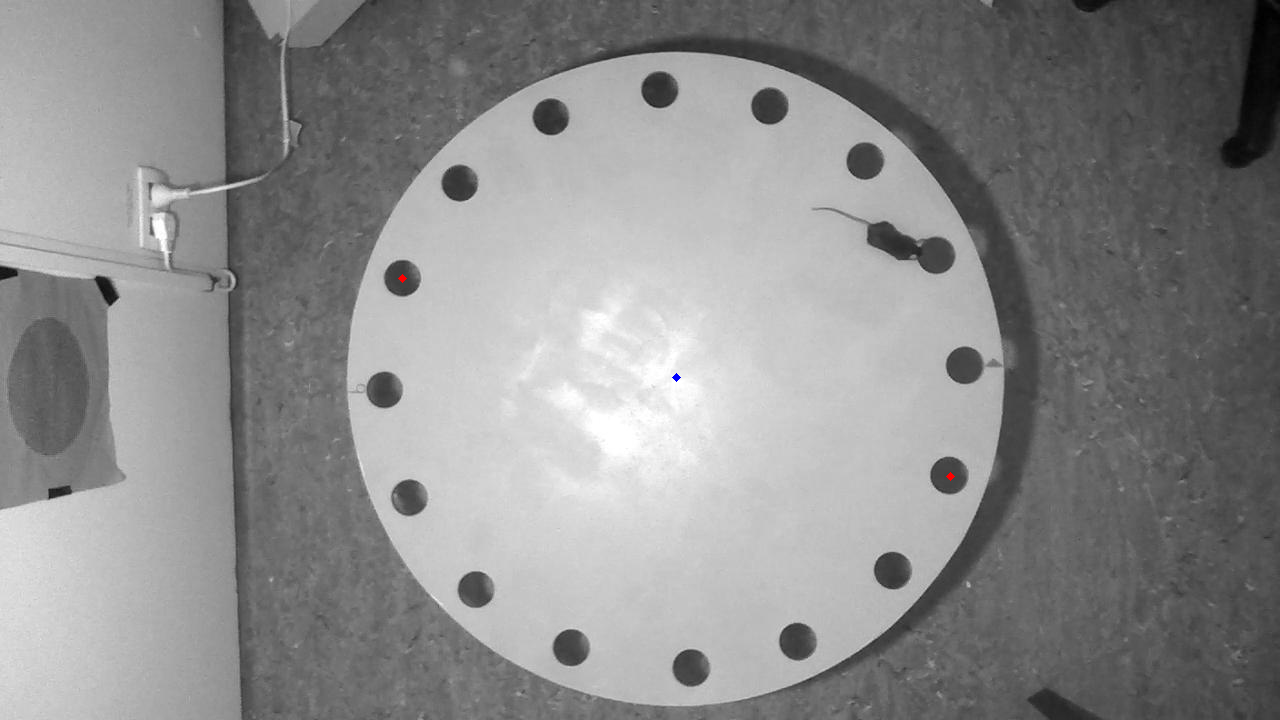

In [60]:
distance_matrix = cdist(circles, circles)

index = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)

circle_one = circles[index[0]]
circle_two = circles[index[1]]

midpoint_between_circles = np.array((int(circle_one[0]+circle_two[0])/2, int(circle_one[1]+circle_two[1])/2), dtype=np.int16)

cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)
cv.circle(cimg,circle_one,2,(0,0,255),3)
cv.circle(cimg,circle_two,2,(0,0,255),3)
cv.circle(cimg,midpoint_between_circles,2,(255,0,0),3)

cv2_imshow(cimg)

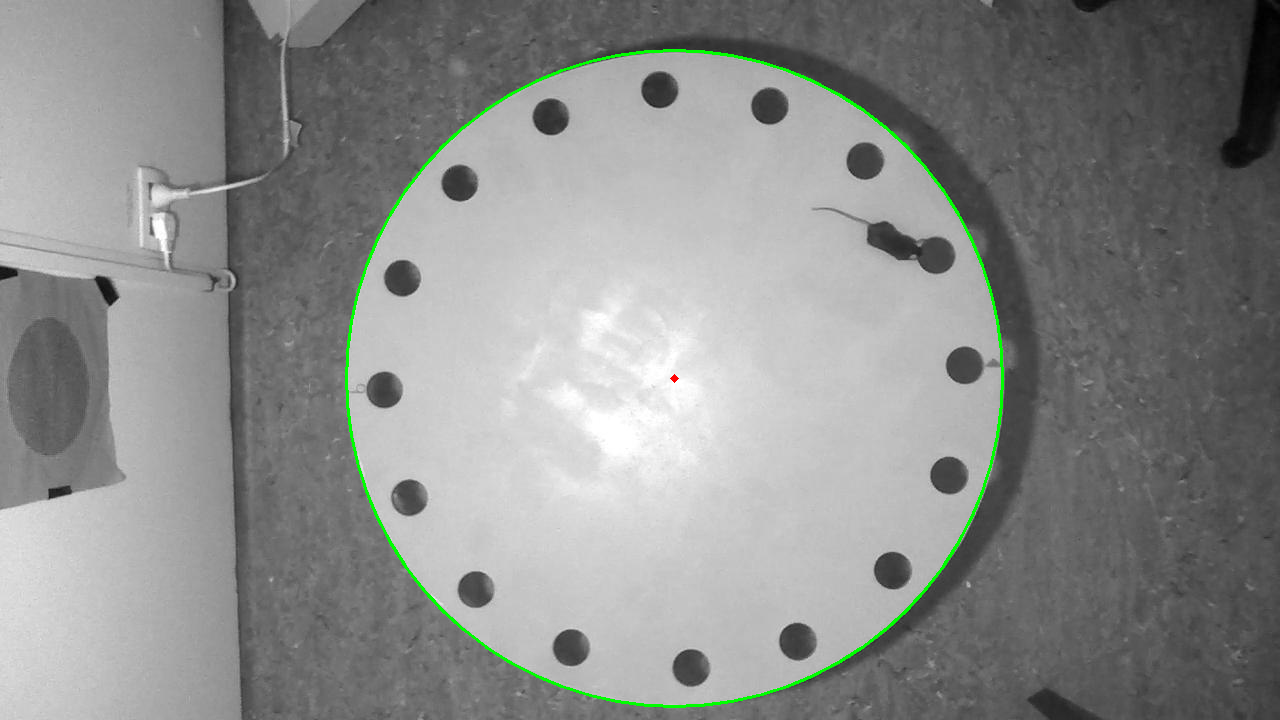

In [61]:
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)
circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20, param1=50,param2=30,minRadius=200,maxRadius=900)
circles = np.uint16(np.around(circles))

distance_matrix = cdist(np.expand_dims(midpoint_between_circles, 0), circles[0,:,0:2])
index = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)
big_circle = circles[0,index[1],:]

cv.circle(cimg,(big_circle[0],big_circle[1]),big_circle[2],(0,255,0),2)
cv.circle(cimg,(big_circle[0],big_circle[1]),2,(0,0,255),3)

cv2_imshow(cimg)

In [62]:
total_area = cimg.shape[0] * cimg.shape[1]
new_area = (big_circle[-1]*2) * (big_circle[-1]*2)
reduced = 1-(new_area/total_area)
print(reduced*100)

53.305555555555564


In [ ]:
clip = mpy.VideoFileClip(video_path)
cropped_clip = crop(clip, width=big_circle[-1]*2, height=big_circle[-1]*2, x_center=big_circle[0], y_center=big_circle[1])
cropped_clip.write_videofile(video_path+'.crop.mp4',codec="libx264")